In [ ]:
import logging #Reports information as the code is run
import os
import sys
import tempfile #makes temporary file directories
import pandas as pd

from glob import glob #function that's used to search for files that match a specific file pattern or name.

import re
import random

import torch
torch.manual_seed(42)
from PIL import Image
from torch.utils.tensorboard import SummaryWriter #Used to make visual bar graphs of epoch running

import numpy as np
import matplotlib.pyplot as plt
import io

from datetime import date
import warnings

from sklearn.model_selection import KFold
from typing import Union, Tuple, List, Callable
from scipy.ndimage import label

In [ ]:
pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import monai
from monai.data import ArrayDataset, Dataset, decollate_batch, DataLoader, list_data_collate
#ArrayDataset -> Used to easily load images and labels as datasets

    # # Create ArrayDataset
    # dataset = ArrayDataset(images, labels, transform=image_transform, seg_transform=label_transform)
#decollate_batch extracts a single image and segmentation from a batch
#DataLoader loads the data in batches and organizes for the computer to operate

from monai.inferers import sliding_window_inference #enables inference on large medical images by dividing them into smaller overlapping windows
from monai.metrics import DiceMetric, MeanIoU #Calcualtes Dice loss 2*Union/(A+B)
from monai.transforms import (
    Activations, #End of neural network activaitons, that turns values from the CNN into probabilities
    AsDiscrete, #Turns probabilites into discrete values
    Compose, #Sums together image transformations
    LoadImage, #Loads image from file directory, converts to tensor format
    LoadImaged,
    RandRotate90,
    RandWeightedCropd,
    RandSpatialCrop,
    RandCropByLabelClasses,
    RandGaussianNoised,
    RandSpatialCropSamples,
    RandRotated,
    # AddChanneld,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld,
    ScaleIntensityd,
    RandRotate90d,
    EnsureChannelFirst,
    EnsureChannelFirstd,
    ToTensord,
    RandCropByPosNegLabel,
    ScaleIntensity,
    AsDiscreted,
    RandRotated,
    RandSpatialCropSamplesd,
    RandSpatialCropd,
    Resized
)
from monai.visualize import plot_2d_or_3d_image
from torch.nn.functional import softmax

In [ ]:
pip install boxsdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 3.5 MB/s eta 0:00:00


In [ ]:
pip install pynrrd

In [ ]:
pip install git+https://github.com/lucasb-eyer/pydensecrf.git

In [ ]:
import boxsdk
from boxsdk import Client, OAuth2

# Define client ID, client secret, and developer token.
ACCESS_TOKEN = "ACCESS_TOKEN"
CLIENT_ID = "CLIENT_ID"
CLIENT_SECRET = "CLIENT_SECRET"

# Create OAuth2 object. It's already authenticated, thanks to the developer token.
oauth2 = OAuth2(CLIENT_ID, CLIENT_SECRET, access_token=ACCESS_TOKEN)

client = Client(oauth2)

In [ ]:
def remove_all_but_largest_component(mask: np.ndarray) -> np.ndarray:
    """
    Keeps only the largest connected component in a binary mask.

    Parameters:
    -----------
    mask : np.ndarray
        A boolean array where True values indicate the foreground.

    Returns:
    --------
    np.ndarray
        A boolean array of the same shape with only the largest component kept.
    """
    labeled_mask, num_components = label(mask)

    if num_components == 0:
        # No components found, return an all-False mask
        return np.zeros_like(mask, dtype=bool)

    # Count the size of each component: bincount gives counts for each label
    component_sizes = np.bincount(labeled_mask.ravel())
    # Ignore label 0 (background)
    largest_component = np.argmax(component_sizes[1:]) + 1

    # Create a mask where only the largest component is kept
    return labeled_mask == largest_component

def remove_all_but_largest_component_from_segmentation(
    segmentation: np.ndarray,
    labels_or_regions: Union[int, Tuple[int, ...], List[Union[int, Tuple[int, ...]]]],
    background_label: int = 0
) -> np.ndarray:
    ret = np.copy(segmentation)  # Don't modify input

    # Normalize to list
    if not isinstance(labels_or_regions, list):
        labels_or_regions = [labels_or_regions]

    for l_or_r in labels_or_regions:
        # Create mask for this label or label group
        mask = region_or_label_to_mask(ret, l_or_r)

        # Keep only the largest component
        mask_keep = remove_all_but_largest_component(mask)

        # Remove from ret everything in this label/group that is not part of the largest component
        if isinstance(l_or_r, tuple):
            for label in l_or_r:
                ret[(ret == label) & ~mask_keep] = background_label
        else:
            ret[(ret == l_or_r) & ~mask_keep] = background_label

    return ret

def region_or_label_to_mask(segmentation: np.ndarray, region_or_label: Union[int, Tuple[int, ...]]) -> np.ndarray:
    if np.isscalar(region_or_label):
        return segmentation == region_or_label
    else:
        mask = np.zeros_like(segmentation, dtype=bool)
        for r in region_or_label:
            mask[segmentation == r] = True
    return mask

In [ ]:
def navigTo(folder, file_name):
    items = folder.get_items()
    for item in items:
        if (item.name == file_name):
            return item
    return -1

def navig(client, file_names):
    folder_init = client.root_folder()
    for i in range(len(file_names)):
        folder_init = navigTo(folder_init, file_names[i])
    return folder_init

In [ ]:
def download_file(client, file_id, file_name):
    file = client.file(file_id).get()
    print(f"Downloading: {file.name}")

    with open(file_name, 'wb') as open_file:
        client.file(file_id).download_to(open_file)

    return file_name

In [ ]:
import nrrd

download_file(client, 1780521548563, "sample_orbit.nrrd")

data, header = nrrd.read("sample_orbit.nrrd")

space_directions = header["space directions"]

# Compute voxel spacing along each axis
voxel_spacing = np.linalg.norm(space_directions, axis=1).tolist()

print("voxel_spacing =", voxel_spacing)
voxel_spacing = [0.3515625, 0.3515625, 3.299999934057465]

Downloading: 1201 AX T1 ORBIT.nrrd
voxel_spacing = [0.3515625, 0.3515625, 3.299999934057465]


In [ ]:
img_file = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', 'cross_validation', 'AX_T1_test_img.npy'])
seg_file = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', 'cross_validation', 'AX_T1_test_seg.npy'])
ID_file = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', 'cross_validation', 'AX_T1_test_id.npy'])

# img_file = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', 'cross_validation', 'POST_AX_T1_FS_test_img.npy'])
# seg_file = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', 'cross_validation', 'POST_AX_T1_FS_test_seg.npy'])
# ID_file = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', 'cross_validation', 'POST_AX_T1_FS_test_id.npy'])

# Obtain numpy arrays from box drive
image_byte_io = io.BytesIO(img_file.get().content())
img = np.load(image_byte_io)
del image_byte_io

# Obtain numpy arrays from box drive
seg_byte_io = io.BytesIO(seg_file.get().content())
seg = np.load(seg_byte_io)
del seg_byte_io

# Obtain numpy arrays from box drive
# fore_byte_io = io.BytesIO(fore_file.get().content())
# fore = np.load(fore_byte_io)
# del fore_byte_io

# Obtain numpy arrays from box drive
ID_io = io.BytesIO(ID_file.get().content())
IDs = np.load(ID_io)
del ID_io

data = {"img": img, "seg": seg, "fore": None, "id": IDs}

In [ ]:
def upload_directory_to_box(client, local_directory, box_folder):
    for root, dirs, files in os.walk(local_directory):
        relative_path = os.path.relpath(root, local_directory)
        current_box_folder = box_folder

        if relative_path != '.':  # Ignore the root directory itself
            folder_name = os.path.basename(root)
            items = current_box_folder.get_items()
            existing_folder = next((item for item in items if item.type == 'folder' and item.name == folder_name), None)

            if existing_folder:
                current_box_folder = client.folder(existing_folder.id)  # Access folder by ID
            else:
                current_box_folder = client.folder(current_box_folder.id).create_subfolder(folder_name)  # Create subfolder from current folder

        # Upload files to the current folder
        for file_name in files:
            file_path = os.path.join(root, file_name)
            existing_files = current_box_folder.get_items()
            existing_file = next((item for item in existing_files if item.name == file_name and item.type == 'file'), None)

            if existing_file:
                existing_file.delete()

            with open(file_path, 'rb') as file_stream:
                current_box_folder.upload_stream(file_stream, file_name)

def save_experiment_to_box(exp_name, client, token = None):
    if (token != None):
        ACCESS_TOKEN = token
        CLIENT_ID = "010e91gvkgovmnwpgtp7etpti2ha4rs9"
        CLIENT_SECRET = "d2uSd1VmN631T9VT7xPJVguZmA0Cggq5"

        # Create OAuth2 object. It's already authenticated, thanks to the developer token.
        oauth2 = OAuth2(CLIENT_ID, CLIENT_SECRET, access_token=ACCESS_TOKEN)

        client = Client(oauth2)

    current_date = date.today()
    formatted_date = current_date.strftime("%m_%d_%y")

    box_directory = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', 'Models', formatted_date])
    if (box_directory == -1):
        box_directory = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', 'Models'])
        box_directory = box_directory.create_subfolder(formatted_date)
    try:
        box_directory = box_directory.create_subfolder(exp_name)
    except:
        box_directory = navig(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', 'Models', formatted_date, exp_name])
    box_folder = box_directory.get()
    upload_directory_to_box(client, exp_name, box_folder)

In [ ]:
NUM_CLASSES = 3

val_transforms = Compose(
    [
        LoadImaged(keys=["img"]),
        EnsureChannelFirstd(keys=["img"]),
        ScaleIntensityd(keys=["img"])
    ]
)

post_trans = Compose(
    [
        Activations(softmax=True),
        AsDiscrete(argmax=True, to_onehot=3)
    ]
)

def sort_image_files(file_list):
    # Sort the file list by extracting the number in "img##.png"
    sorted_files = sorted(file_list, key=lambda x: int(re.search(r'\d+', x[x.rfind("/")+1:]).group()))
    return sorted_files

In [ ]:
def load_model(client, file_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    box_model = navig(client, file_name)
    image_byte_io = io.BytesIO(box_model.get().content())

    if (device.__str__() == "cpu"):
        model_params = torch.load(image_byte_io, map_location="cpu")
    else:
        model_params = torch.load(image_byte_io)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=3,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    model.load_state_dict(model_params)
    model.eval()

    return model

def try_model(model, data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with tempfile.TemporaryDirectory() as tempdir:

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        img = data["img"]
        # seg = data["seg"]

        print("Loaded Data")

        # Load data to tempdir
        print(f"generating synthetic data to {tempdir} (this may take a while)")
        for i in range(len(img)): #Make 40 such images
            Image.fromarray((img[i]).astype("uint16")).save(os.path.join(tempdir, f"img{i:d}.png")) #Saves the image numpys in  temp directory as a png
            # Image.fromarray((seg[i]).astype("uint8")).save(os.path.join(tempdir, f"seg{i:d}.png")) #Saves the segmentation numpys in  temp directory as a png
        images = sort_image_files(glob(os.path.join(tempdir, "img*.png")))
        # segmentations = sort_image_files(glob(os.path.join(tempdir, "seg*.png")))

        # files = [{"img": imgs, "seg": segs} for imgs, segs in zip(images, segmentations)]
        files = [{"img": imgs} for imgs in images]

        val_ds = Dataset(data=files, transform=val_transforms)
        val_loader = DataLoader(val_ds, batch_size=8, num_workers=1, collate_fn=list_data_collate, shuffle=False)

        all_outputs = []

        for i, batch in enumerate(val_loader):
            print(i)
            inputs = batch["img"].to(device)

            # Get model predictions
            val_outputs = sliding_window_inference(inputs, (128, 128), 1, model)

            # Convert to (B, H, W) by taking argmax over class/channel dimension
            preds = torch.argmax(val_outputs, dim=1)

            # Move to CPU and convert to NumPy
            preds_np = preds.cpu().numpy()  # shape: (B, H, W)

            # Append to list
            all_outputs.append(preds_np.transpose(0, 2, 1))

        # Stack all outputs into one array
        combined_outputs = np.concatenate(all_outputs, axis=0)  # shape: (slices, x, y)

        return combined_outputs

In [ ]:
model = load_model(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', 'Models', "06_01_25", "AX_T1_cross_validation_scheduledLR_refined_spatial_targetted_sampling_resize_DICE_wo_crf", "models", "most_recent_model.pth"])
most_recent_output = try_model(model, data)

Loaded Data
generating synthetic data to /tmp/tmpq4ziigkn (this may take a while)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [ ]:
model = load_model(client, ['02_mri', '00_uchicago_data', 'Lacrimal Gland MRI for training', 'numpy_data', 'Models', "06_01_25", "AX_T1_cross_validation_scheduledLR_refined_spatial_targetted_sampling_resize_DICE_wo_crf", "models", "best_metric_model.pth"])
best_metric_output = try_model(model, data)

Loaded Data
generating synthetic data to /tmp/tmp96h5ydyq (this may take a while)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [ ]:
np.save("AX_T1_most_recent_output.npy", most_recent_output)

In [ ]:
download_file(client, 1895664419677, "AX_T1_test_output.npy")
AX_T1_test_output = np.load("AX_T1_test_output.npy")
AX_T1_test_output_clean = np.zeros(AX_T1_test_output.shape)
for i, slice in enumerate(AX_T1_test_output):
    AX_T1_test_output_clean[i] = remove_all_but_largest_component_from_segmentation(slice, labels_or_regions=[1,2], background_label = 0)

Downloading: AX_T1_most_recent_output.npy


In [ ]:
def get_3D_scans(AX_T1_IDs, gt, out, img):
    AX_T1_gt_seg = gt
    AX_T1_out_seg = out
    threeD_gt_segs = []
    threeD_out_segs = []
    curr_scan_id = None
    gt_slices = []
    out_slices = []
    for i, ID in enumerate(AX_T1_IDs):
        # print(ID, curr_scan_id, len(gt_slices), len(out_slices))
        if (curr_scan_id == ID):
            # print("Appending")
            gt_slices.append(AX_T1_gt_seg[i])
            out_slices.append(AX_T1_out_seg[i])
        else:
            if (len(gt_slices) > 0):
                # print("Saving")
                threeD_gt_segs.append(np.stack(gt_slices))
                threeD_out_segs.append(np.stack(out_slices))
                gt_slices = []
                out_slices = []
            curr_scan_id = ID
    if (len(gt_slices) > 0):
        # print("Saving")
        threeD_gt_segs.append(np.stack(gt_slices))
        threeD_out_segs.append(np.stack(out_slices))
        gt_slices = []
        out_slices = []

    print("len", len(gt_slices))

    return {"GT": threeD_gt_segs, "Out": threeD_out_segs}

In [ ]:
def get_3D_scans(AX_T1_IDs, gt, out, img):
    AX_T1_gt_seg = gt
    AX_T1_out_seg = out
    AX_T1_img = img

    threeD_gt_segs = []
    threeD_out_segs = []
    threeD_imgs = []
    threeD_ids = []

    curr_scan_id = None
    gt_slices = []
    out_slices = []
    img_slices = []

    for i, ID in enumerate(AX_T1_IDs):
        if curr_scan_id == ID:
            gt_slices.append(AX_T1_gt_seg[i])
            out_slices.append(AX_T1_out_seg[i])
            img_slices.append(AX_T1_img[i])
        else:
            threeD_ids.append(ID)
            if len(gt_slices) > 0:
                threeD_gt_segs.append(np.stack(gt_slices))
                threeD_out_segs.append(np.stack(out_slices))
                threeD_imgs.append(np.stack(img_slices))
                gt_slices = []
                out_slices = []
                img_slices = []
            curr_scan_id = ID
            gt_slices.append(AX_T1_gt_seg[i])
            out_slices.append(AX_T1_out_seg[i])
            img_slices.append(AX_T1_img[i])

    # Save the last scan
    if len(gt_slices) > 0:
        threeD_gt_segs.append(np.stack(gt_slices))
        threeD_out_segs.append(np.stack(out_slices))
        threeD_imgs.append(np.stack(img_slices))

    return {"GT": threeD_gt_segs, "Out": threeD_out_segs, "Img": threeD_imgs, "ID": threeD_ids}

In [ ]:
scans_3D = get_3D_scans(data["id"], gt = data["seg"], out = AX_T1_test_output_clean, img = data["img"])

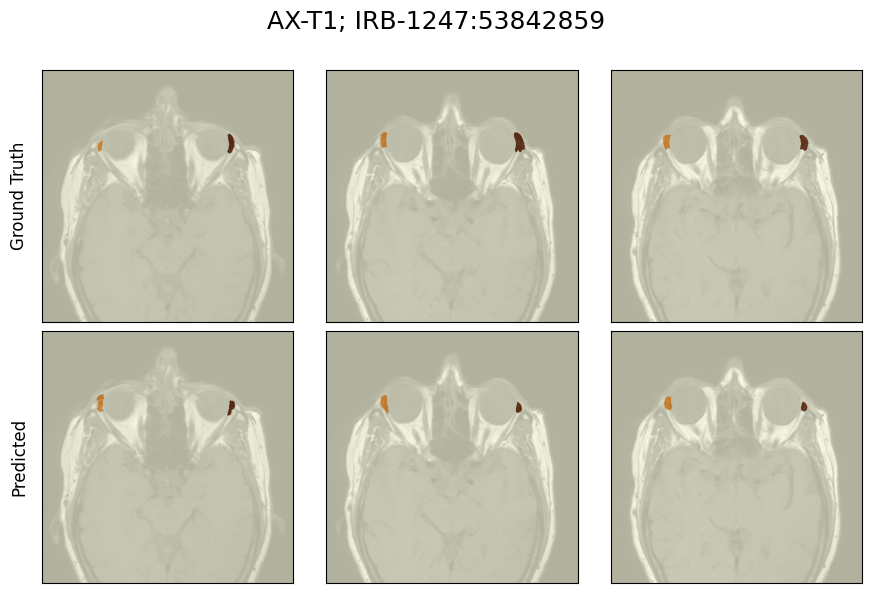

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

target_id = "53842859"

# Assuming these are lists of 3D arrays: [D, H, W]
try:
    idx = scans_3D["ID"].index(target_id)
except ValueError:
    raise ValueError(f"Scan ID {target_id} not found in scans_3D['ID']")

# Retrieve the corresponding scan
gt = scans_3D["GT"][idx]
pred = scans_3D["Out"][idx]
img = scans_3D["Img"][idx]

# Find the slice with the max GT area
slice_areas = gt.reshape(gt.shape[0], -1).sum(axis=1)
max_slice_idx = np.argmax(slice_areas)

# Get a few slices around the max one for display (e.g., -1, 0, +1)
slice_indices = [max_slice_idx - 1, max_slice_idx, max_slice_idx + 1]
slice_indices = [i for i in slice_indices if 0 <= i < gt.shape[0]]

# Plot
fig, axs = plt.subplots(2, len(slice_indices), figsize=(3 * len(slice_indices), 6))

for col, slice_idx in enumerate(slice_indices):
    img_slice = img[slice_idx]
    gt_slice = gt[slice_idx]
    pred_slice = pred[slice_idx]

    # Ground Truth
    axs[0, col].imshow(img_slice, cmap="gray")
    axs[0, col].imshow(gt_slice, cmap="YlOrBr", alpha=0.7)
    axs[0, col].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    if col == 0:
        axs[0, col].set_ylabel("Ground Truth", fontsize=12, rotation=90, labelpad=10)

    # Predicted Segmentation
    axs[1, col].imshow(img_slice, cmap="gray")
    axs[1, col].imshow(pred_slice, cmap="YlOrBr", alpha=0.7)
    axs[1, col].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    if col == 0:
        axs[1, col].set_ylabel("Segmentation", fontsize=12, rotation=90, labelpad=10)

axs[0, 0].set_ylabel("Ground Truth", fontsize=12)
axs[1, 0].set_ylabel("Predicted", fontsize=12)

dice_val = 0.8
iou_val = 0.66
plt.suptitle(f"AX-T1; IRB-1247:{target_id}", fontsize=18)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

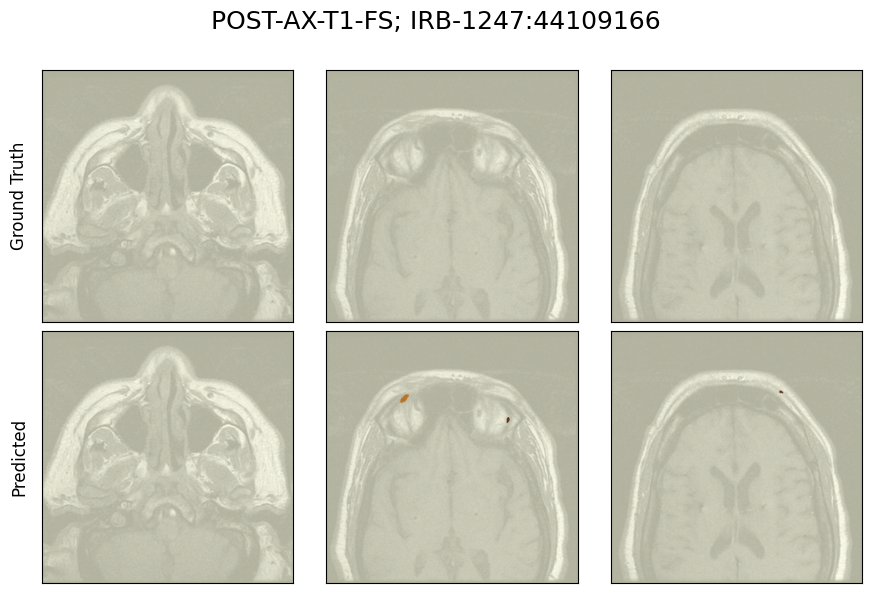

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

target_id = "44109166"

# Assuming these are lists of 3D arrays: [D, H, W]
try:
    idx = scans_3D["ID"].index(target_id)
except ValueError:
    raise ValueError(f"Scan ID {target_id} not found in scans_3D['ID']")

# Retrieve the corresponding scan
gt = scans_3D["GT"][idx]
pred = scans_3D["Out"][idx]
img = scans_3D["Img"][idx]

num_slices = 3  # or any number you want
slice_indices = sorted(random.sample(range(gt.shape[0]), num_slices))

# Plot
fig, axs = plt.subplots(2, len(slice_indices), figsize=(3 * len(slice_indices), 6))

for col, slice_idx in enumerate(slice_indices):
    img_slice = img[slice_idx]
    gt_slice = gt[slice_idx]
    pred_slice = pred[slice_idx]

    # Ground Truth
    axs[0, col].imshow(img_slice, cmap="gray")
    axs[0, col].imshow(gt_slice, cmap="YlOrBr", alpha=0.7)
    axs[0, col].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    if col == 0:
        axs[0, col].set_ylabel("Ground Truth", fontsize=12, rotation=90, labelpad=10)

    # Predicted Segmentation
    axs[1, col].imshow(img_slice, cmap="gray")
    axs[1, col].imshow(pred_slice, cmap="YlOrBr", alpha=0.7)
    axs[1, col].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    if col == 0:
        axs[1, col].set_ylabel("Segmentation", fontsize=12, rotation=90, labelpad=10)

axs[0, 0].set_ylabel("Ground Truth", fontsize=12)
axs[1, 0].set_ylabel("Predicted", fontsize=12)

dice_val = 0.8
iou_val = 0.66
plt.suptitle(f"POST-AX-T1-FS; IRB-1247:{target_id}", fontsize=18)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
gt_scans_3d = scans_3D["GT"]
out_scans_3d = scans_3D["Out"]
gt_volumes = []
out_volumes = []
for i, gt_scan in enumerate(gt_scans_3d):
    np.sum(gt_scan)
    np.sum(out_scans_3d[i])
    gt_volumes.append(np.sum(gt_scan) * np.prod(voxel_spacing))
    out_volumes.append(np.sum(out_scans_3d[i]) * np.prod(voxel_spacing))

In [ ]:
np.array(gt_volumes)-np.array(out_volumes)

array([  55.26603588, -142.54966451, -412.04806458, -465.17279649,
       -102.98652443,  -72.39646767, -272.76133946,  -53.94046676,
       -196.89799869,   74.02793736,  386.14848319,  433.56307117,
        456.19971317,  137.85918914])

In [ ]:
scans_3D["ID"]

[np.str_('12698880'),
 np.str_('17597334'),
 np.str_('22543656'),
 np.str_('38041148'),
 np.str_('41084905'),
 np.str_('44109166'),
 np.str_('49616004'),
 np.str_('53842859'),
 np.str_('62670351'),
 np.str_('70098571'),
 np.str_('78838690'),
 np.str_('91833509'),
 np.str_('95553395'),
 np.str_('96815178')]

In [ ]:
np.prod(voxel_spacing)

np.float64(0.4078674234903788)

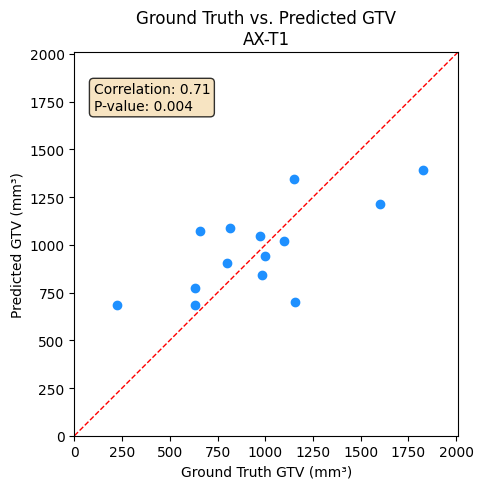

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

# Calculate correlation
corr, pval = pearsonr(gt_volumes, out_volumes)

# Plot
plt.figure(figsize=(5, 5))  # Square figure
plt.scatter(gt_volumes, out_volumes, color='dodgerblue')

# Identity line
max_val = max(max(gt_volumes), max(out_volumes)) * 1.1
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=1)

# Labels and title
plt.xlabel("Ground Truth GTV (mm³)")
plt.ylabel("Predicted GTV (mm³)")
plt.title("Ground Truth vs. Predicted GTV\nAX-T1")

# Text box for correlation
textstr = f"Correlation: {corr:.2f}\nP-value: {pval:.3f}"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.05 * max_val, 0.85 * max_val, textstr, fontsize=10, bbox=props)

# Axis limits and aspect ratio
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [ ]:
def convert_tensor_list_to_numpy(tensor_list):
    class_0_vals = []
    class_1_vals = []

    for t in tensor_list:
        # Skip entirely NaN tensors if needed
        if t is None or t.numel() == 0:
            class_0_vals.append(np.nan)
            class_1_vals.append(np.nan)
            continue

        # Detach and convert to numpy
        arr = t.detach().cpu().numpy().squeeze()  # shape (2,)
        if arr.shape[0] != 2:
            raise ValueError(f"Expected tensor with 2 values, got shape {arr.shape}")

        class_0_vals.append(arr[0])
        class_1_vals.append(arr[1])

    return np.array(class_0_vals), np.array(class_1_vals)

In [ ]:
import numpy as np
import torch
from monai.metrics import DiceMetric, MeanIoU, HausdorffDistanceMetric

def compute_metrics_per_sample(pred_volumes, label_volumes, voxel_spacing = [0.3515625, 0.3515625, 3.299999934057465], smoothing = False):
    assert len(pred_volumes) == len(label_volumes), "Mismatch in number of predictions and labels"

    if (smoothing):
        dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=True, smooth_nr=1e-5, smooth_dr=1e-5)
        iou_metric = MeanIoU(include_background=False, reduction="mean", get_not_nans=True, smooth_nr=1e-5, smooth_dr=1e-5)
        hd_metric = HausdorffDistanceMetric(
            include_background=False,   # Only compute for foreground classes
            percentile=95.0,
            reduction="mean",           # Get HD per class per case
            get_not_nans=True, smooth_nr=1e-5, smooth_dr=1e-5
        )
    else:
        dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=True)
        iou_metric = MeanIoU(include_background=False, reduction="mean", get_not_nans=True)
        hd_metric = HausdorffDistanceMetric(
            include_background=False,   # Only compute for foreground classes
            percentile=95.0,
            reduction="mean",           # Get HD per class per case
            get_not_nans=True
        )

    dice_scores = []
    iou_scores = []
    hausdorff_scores = []

    for pred_np, label_np in zip(pred_volumes, label_volumes):
        assert pred_np.shape == label_np.shape, "Shape mismatch for current prediction and label"

        num_classes = 3
        pred_np = pred_np.astype(np.int8)
        # print(np.unique(pred_np))
        # print(np.unique(label_np))
        pred_np = np.eye(num_classes)[pred_np].transpose(2, 0, 1)
        label_np = np.eye(num_classes)[label_np].transpose(2, 0, 1)

        # Convert to tensor and add channel and batch dims: [1, 1, H, W, D]
        pred = torch.tensor(pred_np[None, ...], dtype=torch.float32)
        label = torch.tensor(label_np[None, ...], dtype=torch.float32)

        # print("pred.shape", pred.shape)
        # print("label.shape", label.shape)

        # Binarize predictions if needed
        pred = (pred > 0.5).float()
        label = (label > 0.5).float()

        # Compute metrics
        dice = dice_metric(pred, label)
        iou = iou_metric(pred, label)
        hd_values = hd_metric(pred, label) * voxel_spacing[0]
        # print(hd_values)
        # hd_cleaned = hd_values[valid_mask.bool()]

        dice_scores.append(dice)
        iou_scores.append(iou)
        hausdorff_scores.append(hd_values)
        # dice_scores.append(dice.item())
        # iou_scores.append(iou.item())
        # hausdorff_scores.append(hd_values.item())

    dice_scores = convert_tensor_list_to_numpy(dice_scores)
    iou_scores = convert_tensor_list_to_numpy(iou_scores)
    hausdorff_scores = convert_tensor_list_to_numpy(hausdorff_scores)

    return {"dice": dice_scores, "iou": iou_scores, "HD": hausdorff_scores}

# Example usage
# preds = [np.random.randint(0, 2, (60, 64, 64)), np.random.randint(0, 2, (80, 64, 64))]
# labels = [np.random.randint(0, 2, (60, 64, 64)), np.random.randint(0, 2, (80, 64, 64))]
# scores = compute_dice_per_sample(preds, labels)
# print(scores)


In [ ]:
best_metric_metrics = compute_metrics_per_sample(AX_T1_test_output_clean, data["seg"])

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:327: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:327: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:332: UserWarning: the prediction of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:332: UserWarning: the pred

In [ ]:
best_metric_metrics["HD"]

(array([       nan,        nan,        nan,        nan,        nan,
         3.2025359,  1.6912478,  3.5238688,  1.40625  ,  0.9943689,
         4.581852 ,  3.4615014,  4.921875 ,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,  5.2155995,  4.2384734,  3.916174 ,
         4.9904428,  2.9954934,  1.4495293,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,  2.2510984,  1.6743019,
         1.9623048,  3.7699454,  4.5384426,  1.7856616,  4.3921776,
         2.4609375,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,  0.703125 ,  0.9943689,  1.792624 ,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,  2.2064753,  1.0

In [ ]:
# Example: best_metric_metrics["HD"] is a pandas Series or a NumPy array
hd_values = best_metric_metrics["HD"]

# Convert to a NumPy array if it's a Series
hd_values = np.array(hd_values)

# Create a boolean mask for non-NaN values
not_nan_mask = ~np.isnan(hd_values)

# Apply the mask and count values > 5
num_greater_than_5 = np.sum(hd_values[not_nan_mask] > 5)

# Total number of non-NaN values
total_non_nan = np.sum(not_nan_mask)

# Compute the ratio
ratio = num_greater_than_5 / total_non_nan if total_non_nan > 0 else np.nan

print(f"Fraction of HD > 5: {ratio:.3f}")

Fraction of HD > 5: 0.205


In [ ]:
plt.imshow(best_metric_output[4])
plt.figure()
plt.imshow(AX_T1_data["seg"][4])

NameError: name 'best_metric_output' is not defined

In [ ]:
most_recent_metrics = compute_metrics_per_sample(most_recent_output, seg)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.metrics.utils get_mask_edges:always_return_as_numpy: Argument `always_return_as_numpy` has been deprecated since version 1.5.0. It will be removed in version 1.7.0. The option is removed and the return type will always be equal to the input type.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:327: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:332: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(


In [ ]:
AX_T1_test_output_clean

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

dice 0.67±0.17 0.9019120102917686 1.7409142855815815e-06
dice 0.71169096 0.58 to 0.79
iou 0.52±0.18 0.9678135379692969 0.015073269190743397
iou 0.5524381 0.41 to 0.66
HD 3.73±2.43 0.8446964345995118 7.590130802451671e-09
HD 3.339605 1.79 to 4.68


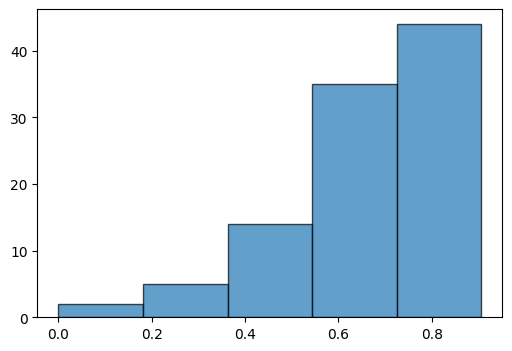

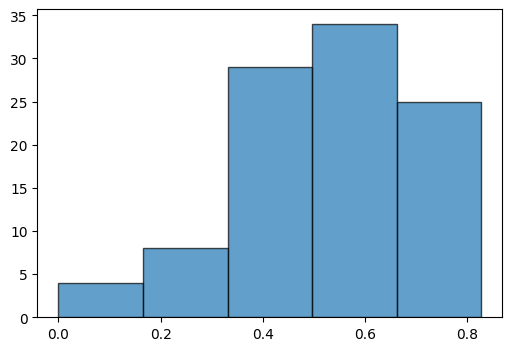

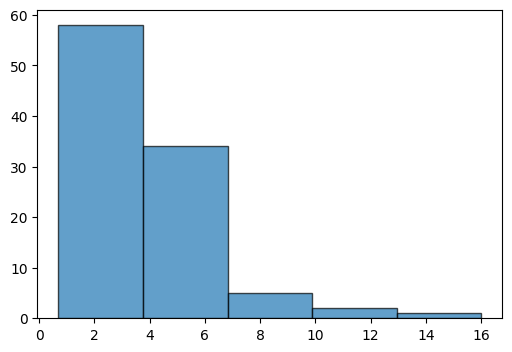

In [ ]:
from scipy.stats import shapiro

# Right lacrimal gland

for key in best_metric_metrics:
    non_nan_metrics = [x for x in best_metric_metrics[key][0] if not np.isnan(x)]
    stat, p_value = shapiro(non_nan_metrics)
    plt.figure(figsize=(6, 4))
    plt.hist(non_nan_metrics, bins=5, edgecolor='black', alpha=0.7)
    print(key, f"{np.mean(non_nan_metrics):.2f} ± {np.std(non_nan_metrics):.2f}", stat, p_value)
    print(key, np.median(non_nan_metrics), f"{np.percentile(non_nan_metrics, 25):.2f} to {np.percentile(non_nan_metrics, 75):.2f}")

dice 0.61±0.23 0.8831470972476297 2.2132012137458906e-07
dice 0.69015545 0.47 to 0.76
iou 0.47±0.21 0.9517399627361391 0.0010114853669189283
iou 0.52689874 0.31 to 0.62
HD 4.84±7.50 0.36327373657031814 7.508390681148314e-19
HD 3.279869 2.17 to 4.73


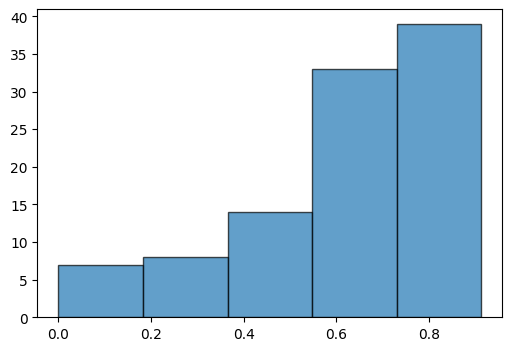

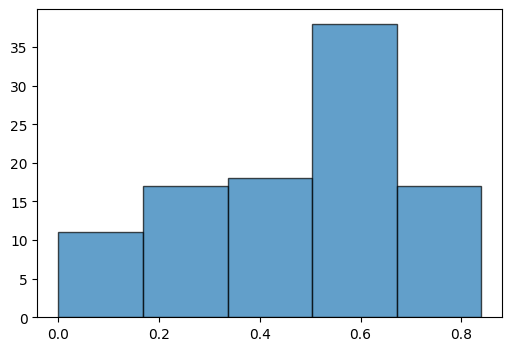

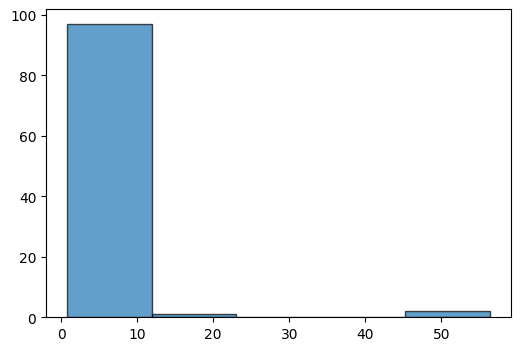

In [ ]:
from scipy.stats import shapiro

# Left lacrimal gland

for key in best_metric_metrics:
    non_nan_metrics = [x for x in best_metric_metrics[key][1] if not np.isnan(x)]
    stat, p_value = shapiro(non_nan_metrics)
    plt.figure(figsize=(6, 4))
    plt.hist(non_nan_metrics, bins=5, edgecolor='black', alpha=0.7)
    print(key, f"{np.mean(non_nan_metrics):.2f} ± {np.std(non_nan_metrics):.2f}", stat, p_value)
    print(key, np.median(non_nan_metrics), f"{np.percentile(non_nan_metrics, 25):.2f} to {np.percentile(non_nan_metrics, 75):.2f}")

In [ ]:
for key in best_metric_metrics:
    non_nan_metrics = [x for x in best_metric_metrics[key] if not np.isnan(x)]
    print(key, np.median(non_nan_metrics), np.std(non_nan_metrics))

dice 0.7441852390766144 0.20385619540749167
iou 0.5925948917865753 0.20547097592368588
HD 2.4734299182891846 32.504154560678295


In [ ]:
for key in most_recent_metrics:
    non_nan_metrics = [x for x in most_recent_metrics[key] if not np.isnan(x)]
    print(key, np.mean(non_nan_metrics), np.std(non_nan_metrics))

dice 0.7623231208029514 0.18653967933031695
iou 0.645640957246845 0.19993007563853202
HD 22.207177825272083 34.65864857495636


In [ ]:
non_nan_dice = [x for x in dice_metrics if not np.isnan(x)]
np.mean(non_nan_dice)

0.6436837518215179

In [ ]:
np.std(non_nan_dice)

0.16766383121435066

In [ ]:
dice_metrics

[nan,
 nan,
 nan,
 nan,
 nan,
 0.5830508470535278,
 0.824999988079071,
 0.6162962913513184,
 0.804519772529602,
 0.8153998255729675,
 0.8204455971717834,
 0.6815920472145081,
 0.3570348024368286,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.3922114074230194,
 0.4437400996685028,
 0.6033629775047302,
 0.5462126731872559,
 0.7302977442741394,
 0.7170868515968323,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.43560606241226196,
 0.7777777910232544,
 0.5939394235610962,
 0.47866418957710266,
 0.7800269722938538,
 0.7942386865615845,
 0.5156069397926331,
 0.7157652378082275,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.8888888955116272,
 0.8604651093482971,
 0.7094594836235046,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.3986486494541168,
 0.7310344576835632,
 0.635477602481842,
 0.73758864402771,
 0.800000011920929,
 0.7621776461601257,
 0.7041666507720947,
 0.6110283136367798,
 nan,
 nan,
 nan,
 nan,
 nan,